In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#package for pearson correlation
from scipy.stats import pearsonr
#package for spearmanr  correlation
from scipy.stats import spearmanr
#package for chisqure significane using contingency
from scipy.stats import chi2_contingency
#package for anova using statamodel.api
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [17]:
#read the data from csv
df= pd.read_csv("C:/Users/maste/Documents/Personal/ML+/Learning/Data preprocessing and EDA/Datasets_Course_Preprocessing_EDA/students.csv")
df_graduated= df[df['graduated']==1]
df_graduated.info()
df.describe()
df_graduated

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753 entries, 11 to 8239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stud.id          1753 non-null   int64  
 1   name             1753 non-null   object 
 2   gender           1753 non-null   object 
 3   age              1753 non-null   int64  
 4   height           1753 non-null   int64  
 5   weight           1753 non-null   float64
 6   religion         1753 non-null   object 
 7   nc.score         1753 non-null   float64
 8   semester         1753 non-null   object 
 9   major            1753 non-null   object 
 10  minor            1753 non-null   object 
 11  score1           1753 non-null   float64
 12  score2           1753 non-null   float64
 13  online.tutorial  1753 non-null   int64  
 14  graduated        1753 non-null   int64  
 15  salary           1753 non-null   float64
dtypes: float64(5), int64(5), object(6)
memory usage: 232.8+ KB


,stud.id,name,gender,age,height,weight,religion,nc.score,semester,major,minor,score1,score2,online.tutorial,graduated,salary
11,200803,"Lang, Mackenzie",Female,22,162,66.8,Other,1.04,4th,Economics and Finance,Environmental Sciences,62.0,61.0,1,1,45254.108021
13,354271,"Covar Orendain, Christopher",Male,23,185,84.6,Orthodox,1.00,4th,Environmental Sciences,Mathematics and Statistics,71.0,76.0,1,1,40552.790243
14,317812,"Lopez, Monique",Female,20,158,64.4,Catholic,2.50,6th,Environmental Sciences,Social Sciences,66.0,70.0,1,1,27007.030294
17,350040,"Hines, Haileigh",Female,22,156,61.7,Other,2.27,6th,Political Science,Biology,57.0,54.0,0,1,33969.159268
28,763393,"Woolsey, Bronson",Male,24,182,80.1,Protestant,1.09,5th,Economics and Finance,Social Sciences,61.0,73.0,1,1,50617.641870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8229,205242,"Hill, Anissa",Female,21,155,63.5,Protestant,1.60,4th,Mathematics and Statistics,Political Science,87.0,86.0,0,1,33259.703079
8234,643038,"Marler, Jalen",Male,24,184,85.1,Other,3.42,5th,Environmental Sciences,Social Sciences,71.0,77.0,1,1,41028.241341
8235,818044,"Her, Joshua",Male,22,181,79.1,Protestant,2.91,6th,Environmental Sciences,Social Sciences,73.0,71.0,0,1,36750.087135
8238,540967,"Ngo, Preston",Male,23,195,98.6,Other,2.74,4th,Social Sciences,Political Science,50.0,46.0,1,1,40112.041834


In [101]:
#we will anova significance test to check the relation between field major & salary. anova gives relation between categorical & numerical col

#random sample for 500 students

import random

unique_student_id= list(df_graduated['stud.id'].unique())
random.seed(30)
sample_student_id=random.sample(unique_student_id,500)
sample_df=df_graduated[df_graduated['stud.id'].isin(sample_student_id)].reset_index(drop=True)


#two variables of interest

sample_df=sample_df[['major','salary']]
groups= sample_df.groupby('major').count().reset_index()
df
groups


,major,salary
0,Biology,87
1,Economics and Finance,94
2,Environmental Sciences,97
3,Mathematics and Statistics,75
4,Political Science,84
5,Social Sciences,63


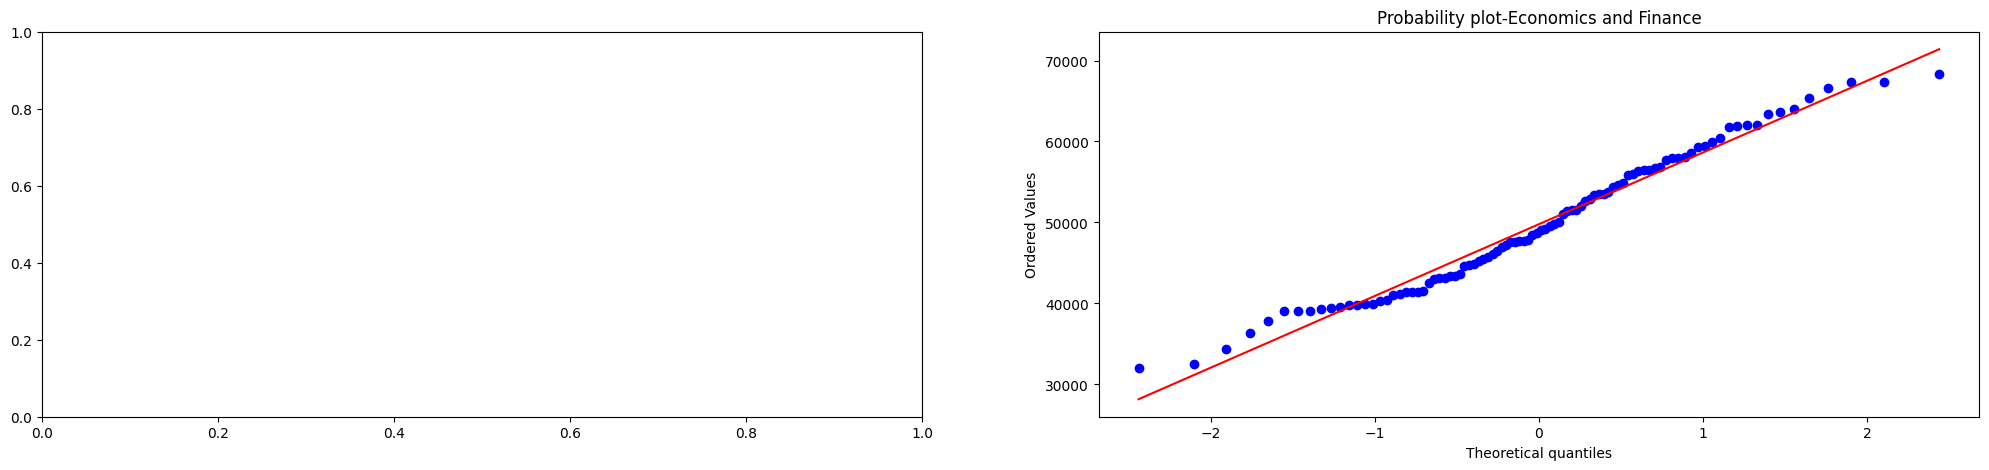

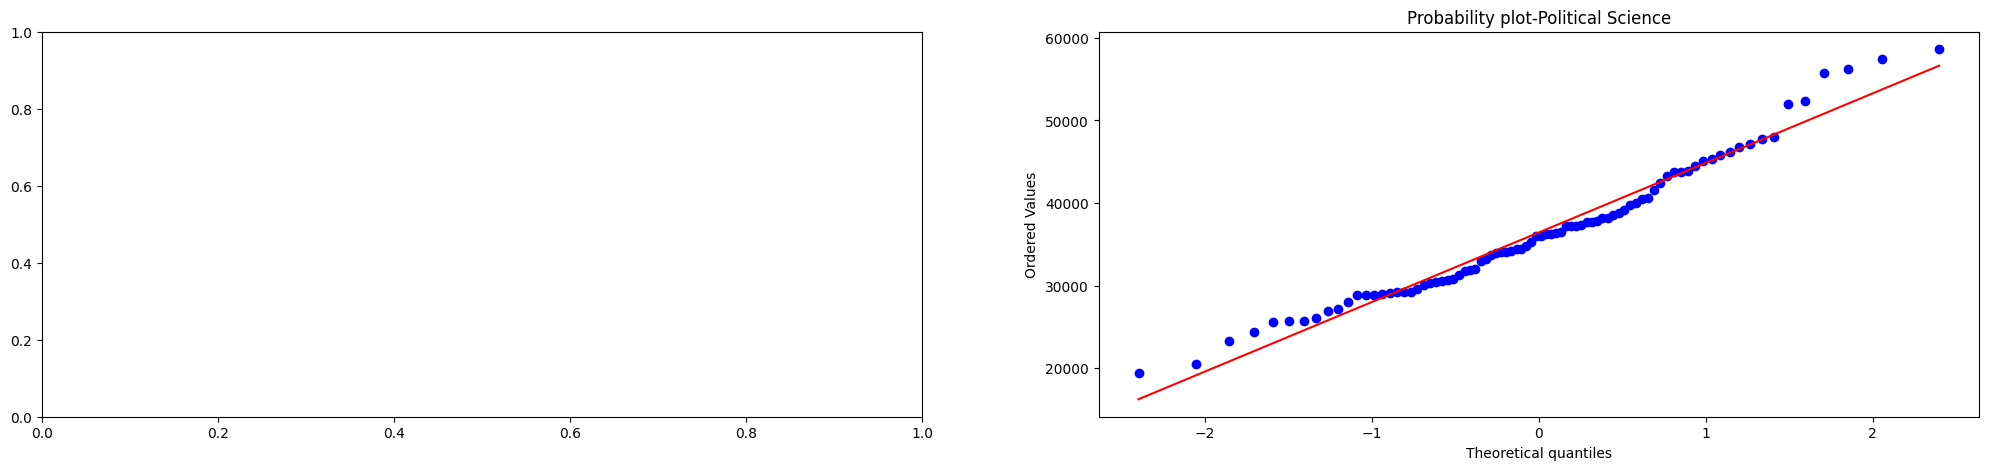

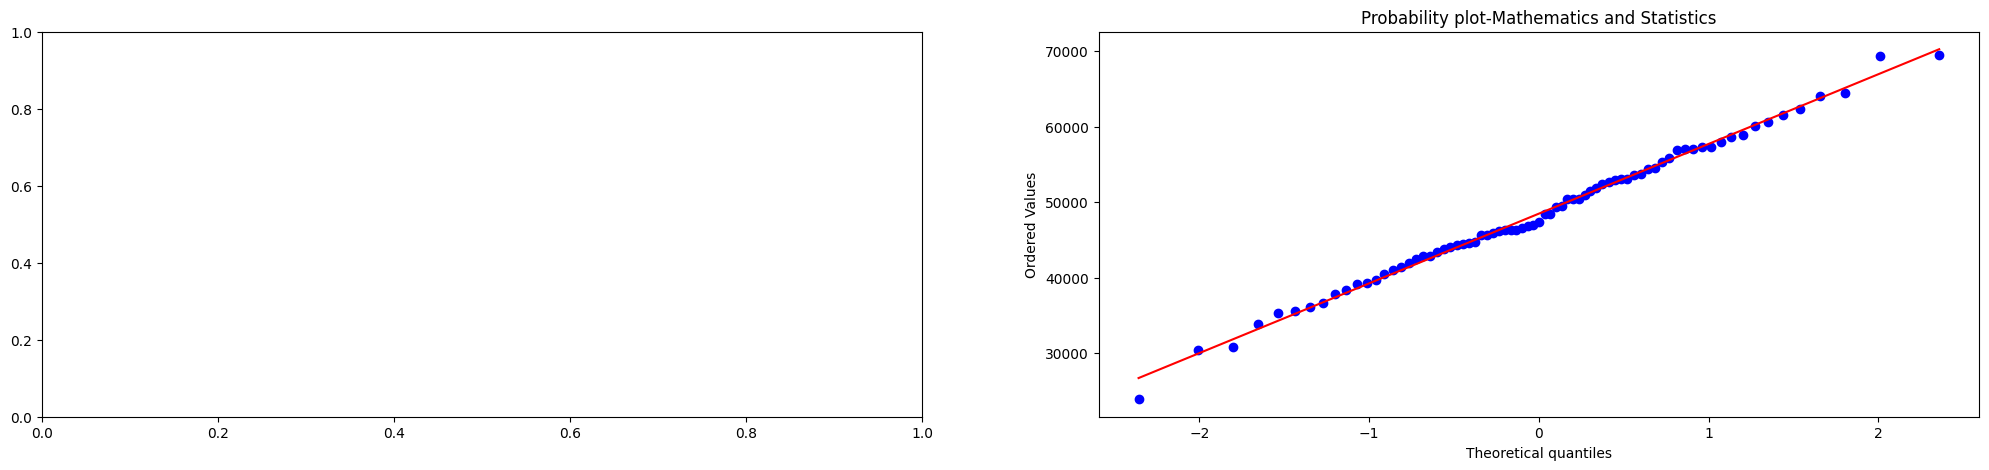

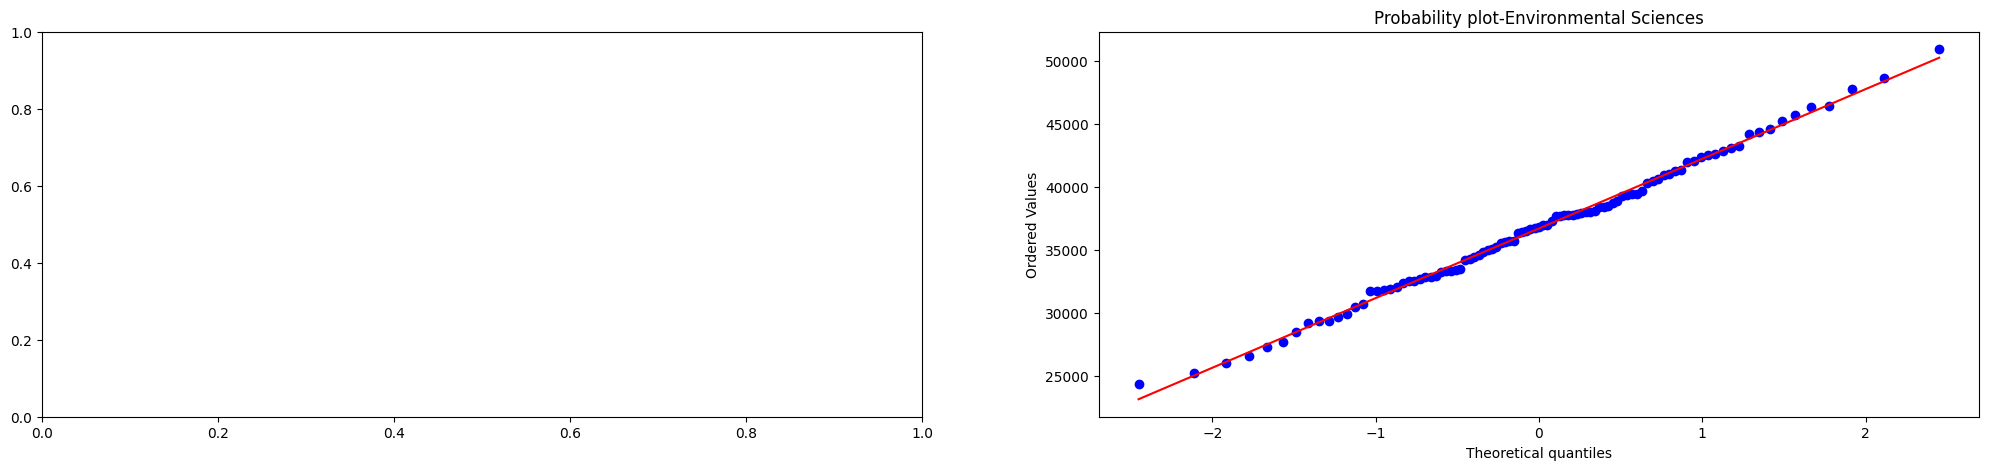

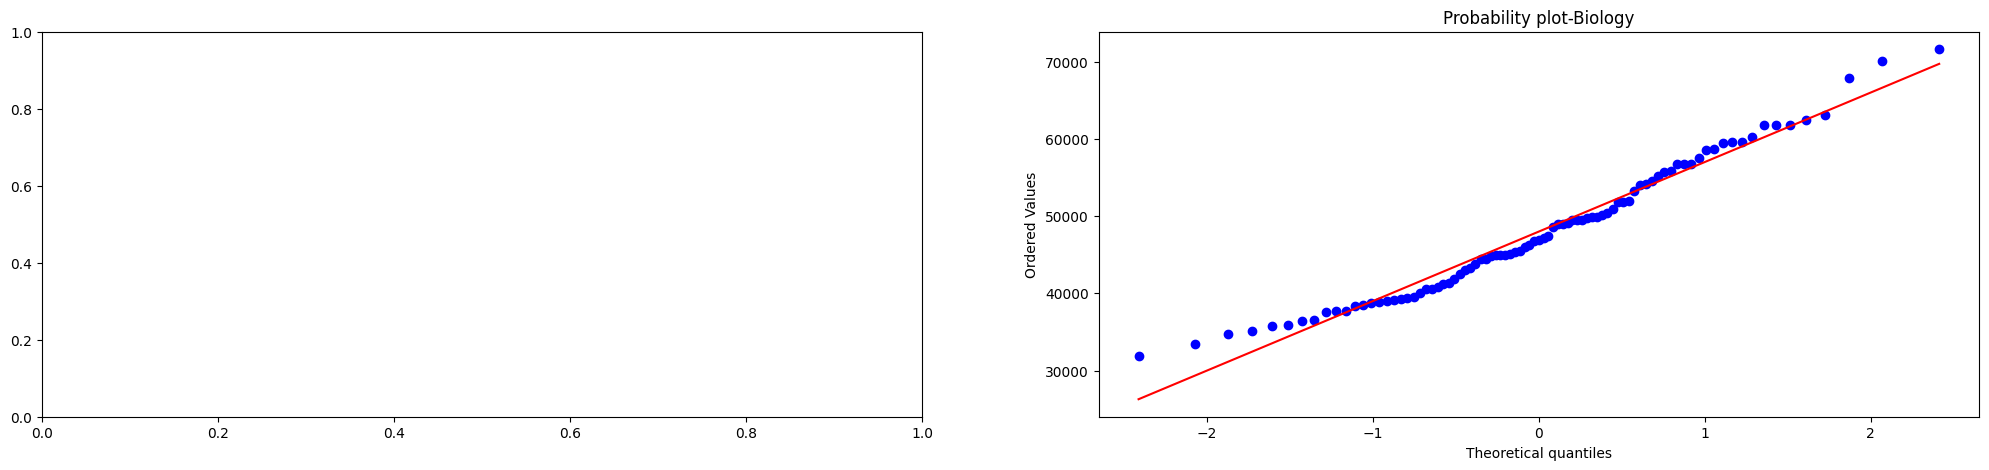

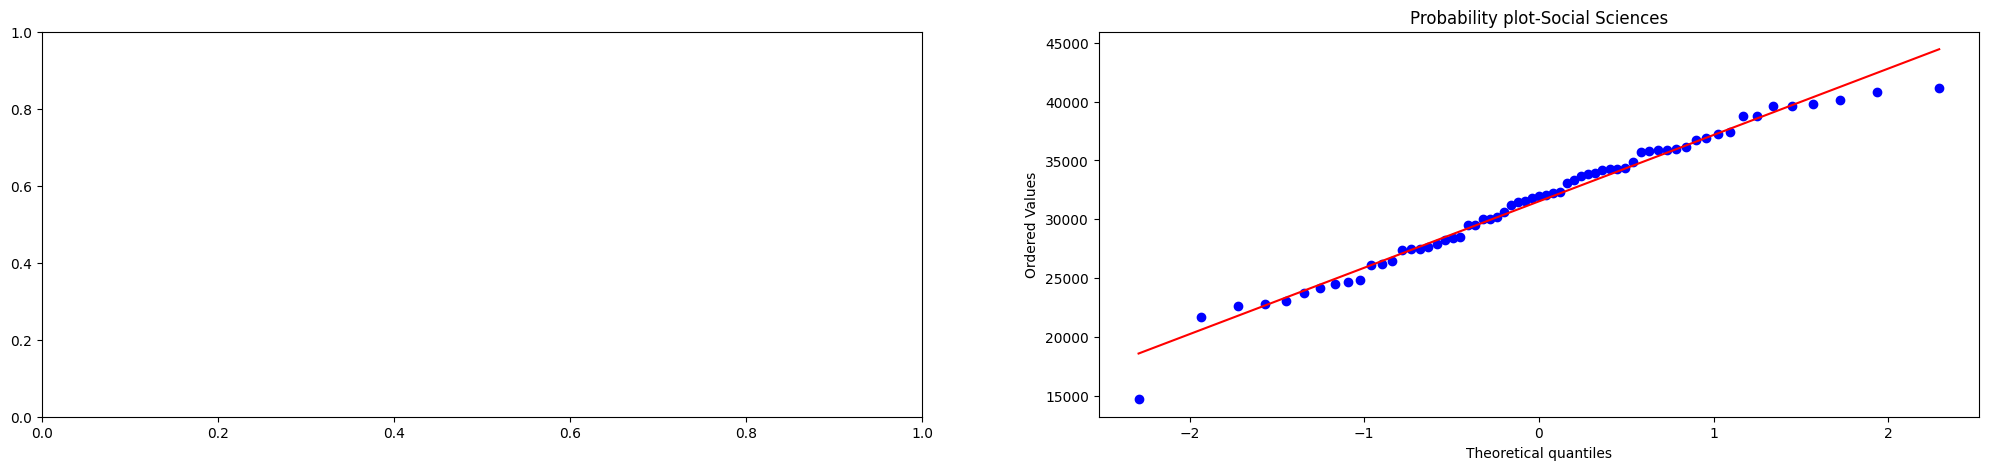

In [50]:
#before we perform we need to check if samples are independent and random using Q-Q plot

import scipy.stats as stats
unique_major = sample_df['major'].unique()

for major in unique_major:
    fig,ax=plt.subplots(1,2,figsize=(25,5))
    stats.probplot(sample_df[sample_df['major']==major]['salary'],dist='norm',plot=plt)
    plt.title("Probability plot-" + major)
    plt.show()

In [53]:
#the above Q-Q plot shows largely straight line pattern

#now we will check the HOMEGENEITY OF VARIANCE ASSUMPTION CHECK

ratio = sample_df.groupby('major').std().max()/sample_df.groupby('major').std().min()
ratio

salary    1.669921
dtype: float64

In [61]:
#the ratios of the largest to the smallest sample standard deviation is 1.67 that is less than the threshold of 2. thus, we conclude that the assumptions are fullfilled

In [126]:
print('Hypothesis testing using ANOVA')

data=[['Between Groups','','','','','',''],['Within Group','','','','','','',],['Total','','','','','','']]
anova_table=pd.DataFrame(data,columns=['Source of variation','SS','Dof','MS','F','P-value','F-crit'])
anova_table.set_index('Source of variation',inplace=True)

#calculate SSTR
x_bar=sample_df['salary'].mean()
SSTR= sample_df.groupby('major').count()*(sample_df.groupby('major').mean()-x_bar)**2
anova_table['SS']['Between Groups']=SSTR['salary'].sum()


#calculate SSE
SSE= (sample_df.groupby('major').count()-1)*sample_df.groupby('major').std()**2
anova_table['SS']['Within Group']=SSE['salary'].sum()

SSTO= SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total']=SSTO

#update degree of freedom
anova_table['Dof']['Between Groups']=sample_df['major'].nunique()-1
anova_table['Dof']['Within Group']=sample_df.shape[0]-sample_df['major'].nunique()
anova_table['Dof']['Total']= sample_df.shape[0]-1


#calculate mean square 

anova_table['MS']=anova_table['SS']/anova_table['Dof']

#calculate f

f= anova_table['MS']['Between Groups']/anova_table['MS']['Within Group']
anova_table['F']['Between Groups']=f

#calcilate p-value

anova_table['P-value']['Between Groups']=1-stats.f.cdf(f,anova_table['Dof']['Between Groups'],anova_table['Dof']['Within Group'])

#f-critical
alpha=0.05

#possible types "right-tailed","left-tailed" and "two-tailed"

anova_table['F-crit']['Between Groups']=stats.f.ppf(1-alpha,anova_table['Dof']['Between Groups'],anova_table['Dof']['Within Group'])



anova_table


Hypothesis testing using ANOVA


,SS,Dof,MS,F,P-value,F-crit
Source of variation,,,,,,
Between Groups,24184075535.074078,5,4836815107.014815,77.408037,0.0,2.232261
Within Group,30867423591.219269,494,62484663.14012,,,
Total,55051499126.29335,499,110323645.543674,,,


In [129]:
print("Approach 1 :  the p-value approach to hypothesis testing")
conclusion="Failed to reject the null hypothesis"
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion ="Null hypothesis is rejected"
print("F-score is :", anova_table["F"]['Between Groups'],"and p value is ",anova_table['P-value']['Between Groups'])
print(conclusion)

Approach 1 :  the p-value approach to hypothesis testing
F-score is : 77.40803685167356 and p value is  1.1102230246251565e-16
Null hypothesis is rejected


Conclusion : We have enough evidence that not all average salaries are the same for graduates of different study subjects.
there is statistically significance between major and salary

